In [ ]:
# Required imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score

In [2]:
# Load the dataset
df = pd.read_csv('processed_dataset_v3.csv') # need to chage the file 
# Display first few rows to understand the structure
df.head()

,sentence,emotion,Tokens,POS_Tags_new,Sentiment_Score_new,GloVe_Embedding_new
0,That game hurt.,sadness,"['that', 'game', 'hurt', '.']","['DET', 'NOUN', 'VERB', 'PUNCT']",-0.5267,"[-0.18378876149654388, 0.21825924515724182, -0..."
1,"You do right, if you don't care then fuck 'em!",neutral,"['you', 'do', 'right', ',', 'if', 'you', 'do',...","['PRON', 'VERB', 'NOUN', 'PUNCT', 'SCONJ', 'PR...",0.1316,"[-0.13493569195270538, 0.12419985234737396, -0..."
2,Man I love reddit.,happiness,"['man', 'i', 'love', 'reddit', '.']","['NOUN', 'PRON', 'VERB', 'PROPN', 'PUNCT']",0.6369,"[-0.0781317949295044, 0.17847399413585663, -0...."
3,"Etenia was nowhere near them, he was by the Fa...",neutral,"['etenia', 'was', 'nowhere', 'near', 'them', '...","['PROPN', 'AUX', 'ADV', 'ADP', 'PRON', 'PUNCT'...",0.0000,"[0.02850472740828991, 0.07425817847251892, -0...."
4,Right? Considering it's such an important docu...,happiness,"['right', '?', 'considering', 'it', ""'s"", 'suc...","['INTJ', 'PUNCT', 'VERB', 'PRON', 'AUX', 'DET'...",0.6239,"[-0.029261890798807144, 0.11021193861961365, -..."


In [3]:
df['Tokens'] = df['Tokens'].apply(ast.literal_eval)
df['POS_Tags_new'] = df['POS_Tags_new'].apply(ast.literal_eval)
df['GloVe_Embedding_new'] = df['GloVe_Embedding_new'].apply(lambda x: np.array(ast.literal_eval(x)))

# Constants
MAX_SEQUENCE_LENGTH = 120
VOCAB_SIZE = 15000
EMBEDDING_DIM = 300


In [4]:
# Cell 3: Clean and prepare text data
# First, check for NaN values
print("Number of NaN values in 'sentence' column:", df['sentence'].isna().sum())
print("\nSample of problematic rows:")
print(df[df['sentence'].isna()].head())

# Clean the data by handling NaN values and ensuring all entries are strings
df['sentence'] = df['sentence'].fillna("")  # Replace NaN with empty string
df['sentence'] = df['sentence'].astype(str)  # Convert all values to strings

# Verify data types
print("\nData type of 'sentence' column:", df['sentence'].dtype)
print("Sample of first few sentences after cleaning:")
print(df['sentence'].head())

# Now proceed with tokenization
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(df['sentence'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['sentence'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

# Print shape of resulting sequences
print("\nShape of padded sequences:", padded_sequences.shape)
print("Sample of first sequence:", padded_sequences[0])

Number of NaN values in 'sentence' column: 1

Sample of problematic rows:
      sentence  emotion Tokens POS_Tags_new  Sentiment_Score_new  \
64912      NaN  neutral     []           []                  0.0   

                                     GloVe_Embedding_new  
64912  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

Data type of 'sentence' column: object
Sample of first few sentences after cleaning:
0                                      That game hurt.
1       You do right, if you don't care then fuck 'em!
2                                   Man I love reddit.
3    Etenia was nowhere near them, he was by the Fa...
4    Right? Considering it's such an important docu...
Name: sentence, dtype: object

Shape of padded sequences: (476771, 120)
Sample of first sequence: [  8 377 263   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  

In [5]:
# Cell 4: Prepare other features
# Sentiment scores - handle NaN values and reshape
sentiment_features = df['Sentiment_Score_new'].fillna(0).values.reshape(-1, 1)

# POS Tags (convert to one-hot encoding)
# First ensure all POS tags are properly loaded
def safe_eval_list(x):
    if isinstance(x, list):
        return x
    try:
        # Remove any whitespace and brackets, then split by comma
        x = str(x).strip('[]').replace("'", "").replace(" ", "")
        return x.split(',') if x else []
    except:
        return []

# Convert POS tags to lists
df['POS_Tags_new'] = df['POS_Tags_new'].fillna('[]').apply(safe_eval_list)

# Create set of unique POS tags
pos_tags_set = set()
for tags in df['POS_Tags_new']:
    if isinstance(tags, list):
        pos_tags_set.update(tags)
pos_tags_list = sorted(list(pos_tags_set))
pos_tag_to_id = {tag: idx for idx, tag in enumerate(pos_tags_list)}

def convert_pos_to_features(pos_tags):
    features = np.zeros(len(pos_tags_list))
    if isinstance(pos_tags, list):
        for tag in pos_tags:
            if tag in pos_tag_to_id:
                features[pos_tag_to_id[tag]] = 1
    return features

pos_features = np.array([convert_pos_to_features(tags) for tags in df['POS_Tags_new']])

# Print shape to verify
print("POS features shape:", pos_features.shape)
print("Number of unique POS tags:", len(pos_tags_list))

# GloVe embeddings - handle NaN values and conversion
def safe_eval_glove(x):
    if isinstance(x, str):
        try:
            # Remove brackets and split by comma
            x = x.strip('[]').replace(" ", "")
            return np.array([float(num) for num in x.split(',') if num])
        except:
            return np.zeros(300)
    return np.zeros(300)

glove_features = np.array([safe_eval_glove(emb) for emb in df['GloVe_Embedding_new']])

# Print shapes to verify
print("Sentiment features shape:", sentiment_features.shape)
print("GloVe features shape:", glove_features.shape)

POS features shape: (476771, 18)
Number of unique POS tags: 18
Sentiment features shape: (476771, 1)
GloVe features shape: (476771, 300)


In [6]:
# Cell 5: Prepare labels
# Map emotions to IDs with error handling
emotion_mapping = {
    'sadness': 1,
    'anger': 2,
    'disgust': 3,
    'fear': 4,
    'surprise': 5,
    'happiness': 6,
    'neutral': 7
}

# Convert emotions to numeric labels with error handling
df['emotion'] = df['emotion'].str.lower()  # Convert to lowercase
df['emotion_id'] = df['emotion'].map(lambda x: emotion_mapping.get(x, 0))
encoded_labels = df['emotion_id'] - 1  # Convert to 0-based indexing
y = tf.keras.utils.to_categorical(encoded_labels)


In [7]:
# Cell 6: Split the data
# Split into training and validation sets
train_ratio = 0.8
X_train_seq, X_val_seq, \
X_train_sent, X_val_sent, \
X_train_pos, X_val_pos, \
X_train_glove, X_val_glove, \
y_train, y_val = train_test_split(
    padded_sequences, 
    sentiment_features,
    pos_features,
    glove_features,
    y,
    test_size=1-train_ratio, 
    random_state=42,
    stratify=encoded_labels  # Ensure balanced split
)

In [8]:
# Cell 7: Build the model
def build_emotion_classifier():
    # Text input
    text_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name='text_input')
    embedding_layer = Embedding(VOCAB_SIZE, 300)(text_input)
    lstm_layer = Bidirectional(LSTM(64, return_sequences=True))(embedding_layer)
    lstm_layer = Bidirectional(LSTM(32))(lstm_layer)
    
    # Sentiment features input
    sentiment_input = Input(shape=(1,), name='sentiment_input')
    
    # POS features input
    pos_input = Input(shape=(len(pos_tags_list),), name='pos_input')
    pos_dense = Dense(16, activation='relu')(pos_input)
    
    # GloVe features input
    glove_input = Input(shape=(300,), name='glove_input')
    glove_dense = Dense(50, activation='relu')(glove_input)
    
    # Concatenate all features
    merged = Concatenate()(
        [lstm_layer, sentiment_input, pos_dense, glove_dense]
    )
    
    # Dense layers with additional regularization
    dense = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(merged)
    dropout = Dropout(0.3)(dense)
    dense = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(dropout)
    dropout = Dropout(0.2)(dense)
    
    # Output layer
    emotion_output = Dense(7, activation='softmax', name='emotion_output')(dropout)
    
    # Create model
    model = Model(
        inputs=[text_input, sentiment_input, pos_input, glove_input],
        outputs=emotion_output
    )
    
    # Compile model with basic metrics
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [9]:
# Cell 8: Create and train the model
from sklearn.metrics import f1_score

# Custom F1 score callback
class F1ScoreCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(F1ScoreCallback, self).__init__()
        self.validation_data = validation_data
        
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
            
        val_x, val_y = self.validation_data
        
        y_pred = self.model.predict(val_x)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(val_y, axis=1)
        
        f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
        
        print(f' - val_f1: {f1:.4f}')
        logs['val_f1'] = f1



### Model training

In [10]:
model = build_emotion_classifier()

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_f1',
    patience=5,
    restore_best_weights=True,
    mode='max'
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_emotion_model.h5',
    monitor='val_f1',
    save_best_only=True,
    mode='max',
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_f1',
    factor=0.2,
    patience=3,
    min_lr=0.00001,
    mode='max'
)

# Create F1 score callback instance
f1_callback = F1ScoreCallback(
    validation_data=(
        [X_val_seq, X_val_sent, X_val_pos, X_val_glove],
        y_val
    )
)
model = build_emotion_classifier()

In [11]:

# Print model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 120)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 120, 300)     4500000     ['text_input[0][0]']             
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 120, 128)    186880      ['embedding_1[0][0]']            
 )                                                                                                
                                                                                                  
 pos_input (InputLayer)         [(None, 18)]         0           []                         

In [12]:
# Train the model
history = model.fit(
    [X_train_seq, X_train_sent, X_train_pos, X_train_glove],
    y_train,
    validation_data=([X_val_seq, X_val_sent, X_val_pos, X_val_glove], y_val),
    epochs=15,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint, reduce_lr, f1_callback]
)

Epoch 1/15
2980/2980 [==============================] - 76s 25ms/step
 - val_f1: 0.8880
11920/11920 [==============================] - 723s 60ms/step - loss: 0.4797 - accuracy: 0.8518 - val_loss: 0.3411 - val_accuracy: 0.8840 - lr: 0.0010 - val_f1: 0.8880
Epoch 2/15
2980/2980 [==============================] - 57s 19ms/step
 - val_f1: 0.8874
11920/11920 [==============================] - 756s 63ms/step - loss: 0.3315 - accuracy: 0.8898 - val_loss: 0.3294 - val_accuracy: 0.8860 - lr: 0.0010 - val_f1: 0.8874
Epoch 3/15
2980/2980 [==============================] - 58s 20ms/step
 - val_f1: 0.8855
11920/11920 [==============================] - 814s 68ms/step - loss: 0.3039 - accuracy: 0.8966 - val_loss: 0.3197 - val_accuracy: 0.8859 - lr: 0.0010 - val_f1: 0.8855
Epoch 4/15
2980/2980 [==============================] - 58s 19ms/step
 - val_f1: 0.8887
11920/11920 [==============================] - 761s 64ms/step - loss: 0.2841 - accuracy: 0.9028 - val_loss: 0.3276 - val_accuracy: 0.8867 - lr: 

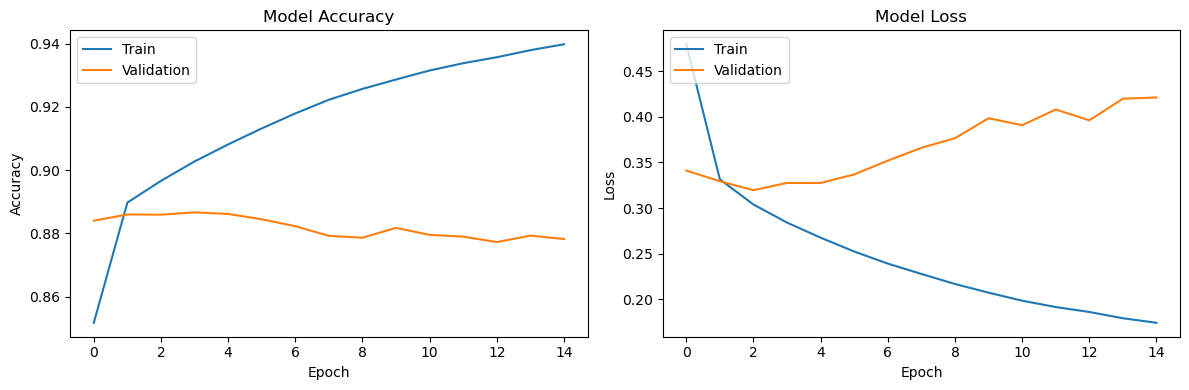

In [14]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


2980/2980 [==============================] - 98s 33ms/step


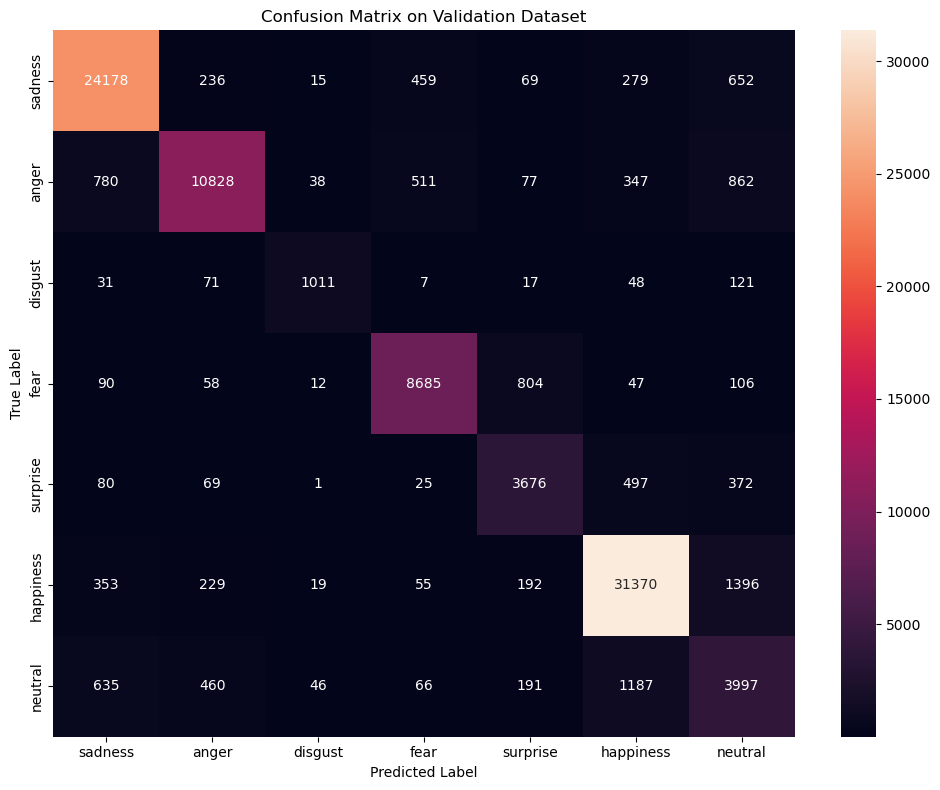


Classification Report:
              precision    recall  f1-score   support

     sadness       0.92      0.93      0.93     25888
       anger       0.91      0.81      0.85     13443
     disgust       0.89      0.77      0.83      1306
        fear       0.89      0.89      0.89      9802
    surprise       0.73      0.78      0.75      4720
   happiness       0.93      0.93      0.93     33614
     neutral       0.53      0.61      0.57      6582

    accuracy                           0.88     95355
   macro avg       0.83      0.82      0.82     95355
weighted avg       0.88      0.88      0.88     95355

Validation Weighted F1 Score: 0.8796


In [16]:
val_predictions = model.predict(
    [X_val_seq, X_val_sent, X_val_pos, X_val_glove]
)

# Get predicted and true emotion labels
val_predicted_emotions = np.argmax(val_predictions, axis=1)
val_true_emotions = np.argmax(y_val, axis=1)

# Generate confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(val_true_emotions, val_predicted_emotions)
emotion_labels = ['sadness', 'anger', 'disgust', 'fear', 'surprise', 'happiness', 'neutral']
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    xticklabels=emotion_labels,
    yticklabels=emotion_labels
)
plt.title('Confusion Matrix on Validation Dataset')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(
    val_true_emotions,
    val_predicted_emotions,
    target_names=emotion_labels
))

# Calculate overall F1 score
val_f1 = f1_score(val_true_emotions, val_predicted_emotions, average='weighted')
print(f"Validation Weighted F1 Score: {val_f1:.4f}")


In [21]:
# Load the external test dataset
test_df = pd.read_excel('test_set_refined.xlsx')
print("External test dataset loaded with shape:", test_df.shape)

External test dataset loaded with shape: (1041, 7)


In [22]:
emotion_mapping = {
    'sadness': 1,
    'anger': 2,
    'disgust': 3,
    'fear': 4,
    'surprise': 5,
    'happiness': 6,
    'neutral': 7
}

# Map granular emotions to main categories
complete_emotion_mapping = {
    "happiness": ["joy", "optimism", "approval", "pride", "gratitude", "love", "excitement", "caring", "relief", "admiration", "amusement", "desire"],
    "sadness": ["disappointment", "remorse", "grief", "sadness"],
    "anger": ["anger", "annoyance", "disapproval"],
    "disgust": ["disgust", "embarrassment"],
    "fear": ["fear", "nervousness"],
    "surprise": ["surprise", "realization", "confusion", "curiosity"],
    "neutral": ["neutral"]
}

# Create flat mapping dictionary
emotion_to_category = {}
for category, emotions in complete_emotion_mapping.items():
    for emotion in emotions:
        emotion_to_category[emotion.lower()] = category

# Apply mapping and handle missing values
test_df['main_emotion'] = test_df['Emotion'].str.lower().map(emotion_to_category)
test_df['main_emotion'] = test_df['main_emotion'].fillna('neutral')

# Convert to model's expected format (0-indexed)
test_df['emotion_id'] = test_df['main_emotion'].map(emotion_mapping)
test_df['emotion_id_0based'] = test_df['emotion_id'] - 1
test_y = tf.keras.utils.to_categorical(test_df['emotion_id_0based'], num_classes=len(emotion_mapping))


In [23]:
test_sequences = tokenizer.texts_to_sequences(test_df['Translation'].astype(str))
test_padded_sequences = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

# Create dummy features matching training data dimensions
test_sentiment = np.zeros((len(test_df), 1))
test_pos = np.zeros((len(test_df), len(pos_tags_list)))
test_glove = np.zeros((len(test_df), 300))

33/33 [==============================] - 1s 21ms/step


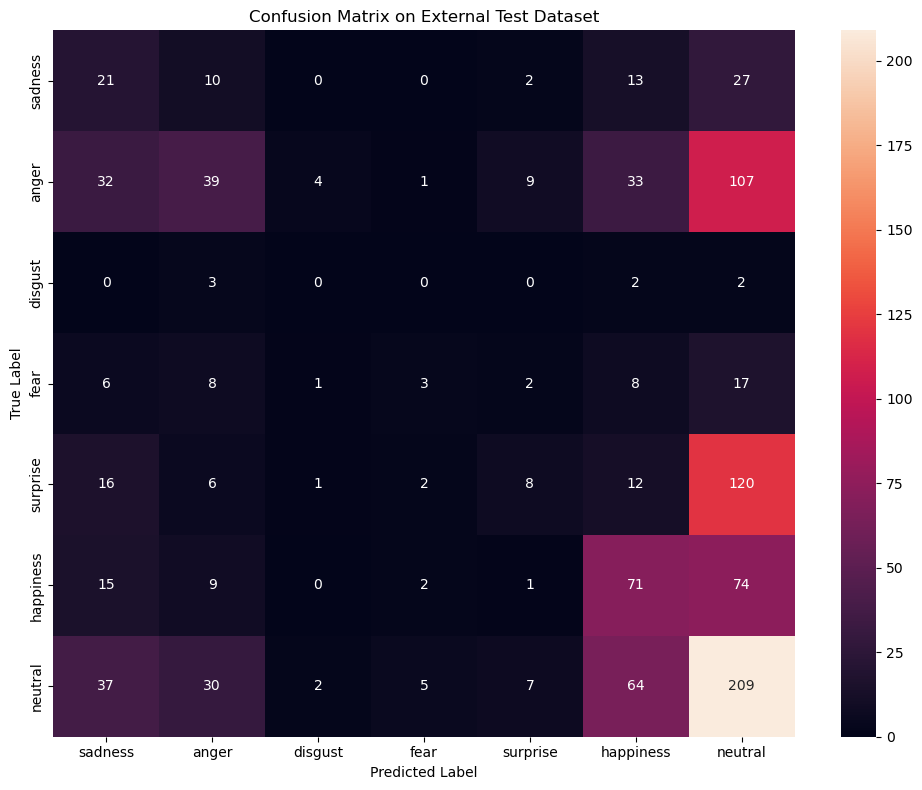


Classification Report for External Test Dataset:
              precision    recall  f1-score   support

     sadness       0.17      0.29      0.21        73
       anger       0.37      0.17      0.24       225
     disgust       0.00      0.00      0.00         7
        fear       0.23      0.07      0.10        45
    surprise       0.28      0.05      0.08       165
   happiness       0.35      0.41      0.38       172
     neutral       0.38      0.59      0.46       354

    accuracy                           0.34      1041
   macro avg       0.25      0.23      0.21      1041
weighted avg       0.33      0.34      0.30      1041

External Test Dataset - Weighted F1 Score: 0.3021


In [24]:
# Cell 5: Make predictions on external test data
external_predictions = model.predict(
    [test_padded_sequences, test_sentiment, test_pos, test_glove]
)

# Get predicted and true emotion labels
external_predicted_emotions = np.argmax(external_predictions, axis=1)
external_true_emotions = np.argmax(test_y, axis=1)

# Generate confusion matrix for external test data
plt.figure(figsize=(10, 8))
external_cm = confusion_matrix(external_true_emotions, external_predicted_emotions)
sns.heatmap(
    external_cm,
    annot=True,
    fmt='d',
    xticklabels=emotion_labels,
    yticklabels=emotion_labels
)
plt.title('Confusion Matrix on External Test Dataset')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Print classification report for external test data
print("\nClassification Report for External Test Dataset:")
print(classification_report(
    external_true_emotions,
    external_predicted_emotions,
    target_names=emotion_labels
))

# Calculate F1 score for external test data
external_f1 = f1_score(external_true_emotions, external_predicted_emotions, average='weighted')
print(f"External Test Dataset - Weighted F1 Score: {external_f1:.4f}")


In [25]:
# Cell 6: Compare performance and save results
print("\nPerformance Comparison:")
print(f"Validation Set F1 Score: {val_f1:.4f}")
print(f"External Test Set F1 Score: {external_f1:.4f}")
print(f"Difference: {abs(val_f1 - external_f1):.4f}")

# Add predictions to the dataframe
test_df['predicted_emotion_id'] = external_predicted_emotions + 1
test_df['predicted_emotion'] = test_df['predicted_emotion_id'].map({v: k for k, v in emotion_mapping.items()})
test_df['prediction_confidence'] = np.max(external_predictions, axis=1)

# Save results
test_df.to_csv('external_test_results.csv', index=False)
print("\nResults saved to 'external_test_results.csv'")


Performance Comparison:
Validation Set F1 Score: 0.8796
External Test Set F1 Score: 0.3021
Difference: 0.5775

Results saved to 'external_test_results.csv'
